# Spark Introduction

This example shows how the Pilot-Abstraction is used to spawn a Spark job inside of YARN. We show how to combine the Pilot and Spark programming modelling using several examples.


   - Spark Documentation: <http://spark.apache.org/docs/latest/>
   - Pilot-Spark: <https://pypi.python.org/pypi/SAGA-Hadoop/>


## 1. Initialize Spark

The following codes show how the Pilot-Abstraction is used to connect to an existing YARN cluster and start Spark.

In [1]:
%matplotlib inline
%run ../env.py
%run ../util/init_spark.py

from pilot_hadoop import PilotComputeService as PilotSparkComputeService

pilotcompute_description = {
    "service_url": "yarn-client://yarn-aws.radical-cybertools.org",
    "number_of_processes": 2
}

print "SPARK HOME: %s"%os.environ["SPARK_HOME"]
print "PYTHONPATH: %s"%os.environ["PYTHONPATH"]

pilot_spark = PilotSparkComputeService.create_pilot(pilotcompute_description=pilotcompute_description)
sc = pilot_spark.get_spark_context()

SPARK Home: /usr/hdp/2.3.2.0-2950/spark-1.5.1-bin-hadoop2.6
SPARK HOME: /usr/hdp/2.3.2.0-2950/spark-1.5.1-bin-hadoop2.6
PYTHONPATH: /usr/hdp/2.3.2.0-2950/spark-1.5.1-bin-hadoop2.6/python:/usr/hdp/2.3.2.0-2950/spark-1.5.1-bin-hadoop2.6/python/lib/py4j-0.8.2.1-src.zip


After the Spark application has been submitted it can be monitored via the YARN web interface: <http://yarn-aws.radical-cybertools.org:8088/>. The following commands prints out the Spark application currently running in YARN

In [2]:
output=!yarn application -list -appTypes Spark -appStates RUNNING
print_application_url(output)

,User,Name,Spark Application URL
0,radical,Pilot-Spark,http://yarn-aws.radical-cybertools.org:8088/proxy/application_1447000128355_0763
1,test073,Pilot-Spark,http://yarn-aws.radical-cybertools.org:8088/proxy/application_1447000128355_0764


## 2. Spark: Hello RDD Abstraction

The RDD Abstraction builts on the popular MapReduce programming model and extends it by supporting a greater variety of transformations!

Here we will use Spark to analyze the NASA log file (that we encountered earlier).

**Line Count:** How many lines of logs do we have?

In [8]:
text_rdd = sc.textFile("/data/nasa/")
text_rdd.count()

1891715

**Word Count:** How many words?

In [5]:
text_rdd.flatMap(lambda line: line.split(" ")).map(lambda word: (word, 1)).reduceByKey(lambda x,y: x+y).take(10)

[(u'', 2817),
 (u'[13/Jul/1995:17:48:56', 1),
 (u'[07/Jul/1995:18:18:55', 1),
 (u'[03/Jul/1995:02:03:49', 1),
 (u'[17/Jul/1995:16:23:45', 1),
 (u'[07/Jul/1995:18:18:51', 1),
 (u'[22/Jul/1995:12:10:41', 1),
 (u'204.97.67.23', 15),
 (u'[03/Jul/1995:02:03:47', 2),
 (u'[16/Jul/1995:14:34:31', 1)]

**HTTP Response Code Count:** How many HTTP errors did we observe?

In [6]:
text_rdd = sc.textFile("/data/nasa/")
text_rdd.filter(lambda x: len(x)>8).map(lambda x: (x.split()[-2],1)).reduceByKey(lambda x,y: x+y).collect()

[(u'403', 54),
 (u'302', 46573),
 (u'304', 132627),
 (u'500', 62),
 (u'501', 14),
 (u'200', 1701534),
 (u'404', 10845),
 (u'400', 5)]

---
Compare the lines of code that were needed to perform the same functionality using MapReduce versus Spark. Which is more?

## 3. Spark-SQL

[Dataframes](http://spark.apache.org/docs/latest/sql-programming-guide.html) are an abstraction that allows high-level reasoning on structured data. Data can easily be filtered, aggregated and combined using DataFrames. DataFrames can also be used for machine learning tasks.

In the following commands, we are transforming unstructured log data into a structured DataFrame consisting of three columns: referer, timestamp and response code. We then sample and view the data.

In [9]:
from pyspark.sql import SQLContext, Row
sqlContext = SQLContext(sc)
text_filtered = text_rdd.filter(lambda x: len(x)>8)
logs = text_filtered.top(20)
cleaned = text_filtered.map(lambda l: (l.split(" ")[0], l.split(" ")[3][1:], l.split(" ")[6], l.split(" ")[-2]))
rows = cleaned.map(lambda l: Row(referer=l[0], ts=l[1], response_code=l[3]))
schemaLog = sqlContext.createDataFrame(rows)
schemaLog.registerTempTable("row")

In [10]:
schemaLog.show()

+--------------------+-------------+--------------------+
|             referer|response_code|                  ts|
+--------------------+-------------+--------------------+
|        199.72.81.55|          200|01/Jul/1995:00:00:01|
|unicomp6.unicomp.net|          200|01/Jul/1995:00:00:06|
|      199.120.110.21|          200|01/Jul/1995:00:00:09|
|  burger.letters.com|          304|01/Jul/1995:00:00:11|
|      199.120.110.21|          200|01/Jul/1995:00:00:11|
|  burger.letters.com|          304|01/Jul/1995:00:00:12|
|  burger.letters.com|          200|01/Jul/1995:00:00:12|
|     205.212.115.106|          200|01/Jul/1995:00:00:12|
|         d104.aa.net|          200|01/Jul/1995:00:00:13|
|      129.94.144.152|          200|01/Jul/1995:00:00:13|
|unicomp6.unicomp.net|          200|01/Jul/1995:00:00:14|
|unicomp6.unicomp.net|          200|01/Jul/1995:00:00:14|
|unicomp6.unicomp.net|          200|01/Jul/1995:00:00:14|
|         d104.aa.net|          200|01/Jul/1995:00:00:15|
|         d104

In [9]:
df=sqlContext.sql("select response_code, count(*) as count from row group by response_code")

In [10]:
df.show()

+-------------+-------+
|response_code|  count|
+-------------+-------+
|          500|     62|
|          501|     14|
|          400|      5|
|          403|     54|
|          404|  10845|
|          302|  46573|
|          304| 132627|
|          200|1701534|
+-------------+-------+



---
Spark Dataframes interoperate with Pandas Dataframes. Small data can be further processed using [Pandas](http://pandas.pydata.org/) and Python tools, e.g. [Matplotlib ](http://matplotlib.org/) and [Bokeh](http://bokeh.pydata.org/) for plotting.

In [11]:
pdf=df.toPandas()

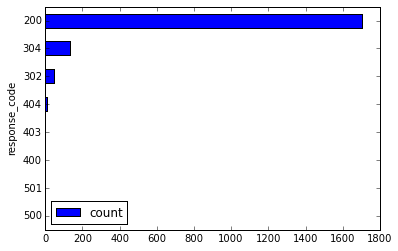

In [12]:
%matplotlib inline
pdf['count']=pdf['count']/1000
pdf.plot(x='response_code', y='count', kind='barh')

## 4. Stop Pilot-Spark Application

In [13]:
pilot_spark.cancel()

## 5. Installation Notes

Pilot-Spark is part of [SAGA-Hadoop](https://pypi.python.org/pypi/SAGA-Hadoop/)

    pip install saga-hadoop